In [23]:
%reload_ext autoreload
%autoreload 2

In [24]:
import numpy as np
from scipy.ndimage import gaussian_filter, rotate
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader

T = torch.from_numpy
TD = TensorDataset
DL = DataLoader

import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('../modules_for_nn_training')
from learner import Learner
from callbacks import CallbackHandler, Callback
from utility_callbacks import LossCallback
from trainer import Trainer

from tqdm import tqdm_notebook

In [25]:
def get_rotation_matrix(deg):
    rad = np.radians(deg)
    c, s = np.cos(rad), np.sin(rad)
    R = np.array(((c, -s), (s, c)))
    return R

In [26]:
x_train = np.array([0.0, 0.25, 0.5, 0.75, 1.0] * 100).reshape(-1, 1)
y_train = np.array([0.0, 0.25, 0.5, 0.75, 1.0] * 100).reshape(-1, 1)

x_valid = np.array([0.0, 0.25, 0.5, 0.75, 1.0] * 100).reshape(-1, 1)
y_valid = np.array([0.0, 0.25, 0.5, 0.75, 1.0] * 100).reshape(-1, 1)

In [27]:
train_ds = TD(T(x_train), T(y_train).float())
train_dl = DL(train_ds, batch_size=64, shuffle=True)

valid_ds = TD(T(x_valid), T(y_valid).float())
valid_dl = DL(valid_ds, batch_size=64, shuffle=False)

In [530]:
class NN(nn.Module):
    
    def __init__(self, num_neurons):
        
        super().__init__()
        
        self.main = nn.Sequential(
            
            nn.Linear(1, num_neurons),
            nn.ReLU(),
            
            nn.Linear(num_neurons, num_neurons),
            nn.ReLU(),
            
            nn.Linear(num_neurons, num_neurons),
            nn.ReLU(),
            
            nn.Linear(num_neurons, 1),
            nn.ReLU(),
        
        )
    
    def forward(self, xb):
        xb = self.main(xb)
        return xb.view(-1, 1)

In [531]:
def get_model(num_neurons):
    nn = NN(num_neurons)
    return nn, optim.Adam(nn.parameters(), lr=1e-4)

In [532]:
def get_tangent_vector(x:np.array)->np.array:
    step = 1e-4
    x_left = x - step
    x_right = x + step
    return (x_right - x_left) / (2 * step)

In [7]:
def get_jacobian(net, x):
    x.requires_grad = True
    y = net(x)
    grad_params = torch.autograd.grad(y, x, create_graph=True)
    return grad_params[0]

In [869]:
get_jacobian(lambda x : 3*x, torch.tensor([[1.]]), 1)

tensor([[3.]])

In [870]:
get_jacobian(trainer.learn.model, train_ds.tensors[0][5].float(), 1)

tensor([-0.0002], grad_fn=<SqueezeBackward1>)

In [1003]:
a = torch.tensor([3.0], requires_grad=False)
b = torch.tensor([2.0], requires_grad=True)
c = a * b

In [1004]:
torch.autograd.grad(c, a, create_graph=True)[0].backward()

RuntimeError: One of the differentiated Tensors does not require grad

In [1005]:
b.grad

## Cannot-be-simpler example of Jacobian regularization

In [115]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
        
    def forward(self, x):
        return self.main(x)

In [116]:
def get_model():
    model = Net()
    return model, optim.Adam(model.parameters(), lr=1e-3)

In [117]:
def sos(ypred, y):
    return torch.sum((ypred - y) ** 2)

In [104]:
data = np.arange(0, 1.1, 0.25)
labels = np.arange(0, 1.1, 0.25)

model, opt = get_model()
jacobian_losses = []
reg_losses = []
for i in tqdm_notebook(range(1000)):
    
    jacobian_loss = 0
    for x in data:
        jacobian = get_jacobian(model, torch.tensor([[x]]))
        temp = torch.sum(jacobian) ** 2
        jacobian_loss += temp
    jacobian_losses.append(float(jacobian_loss))

    ypred = model(torch.tensor(data).view(-1, 1).float())
    loss = sos(ypred, torch.tensor(labels).view(-1, 1))
    reg_losses.append(float(loss))
    
    total_loss = loss + 0.1 * jacobian_loss
    
    total_loss.backward()
    opt.step()
    opt.zero_grad()

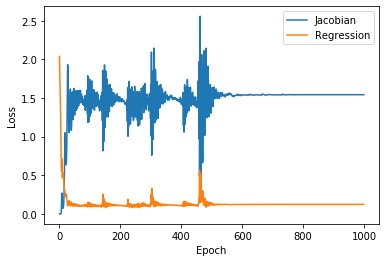

In [105]:
plt.plot(jacobian_losses, label='Jacobian')
plt.plot(reg_losses, label='Regression')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()
plt.show()


In [122]:
data = [0, 0.20, 0.25, 0.30, 0.5, 0.75, 1.0]
labels = [0, 0.25, 0.25, 0.25, 0.5, 0.75, 1.0]

model, opt = get_model()
jacobian_losses = []
reg_losses = []
for i in range(300):
    
    ypred = model(torch.tensor(data).view(-1, 1).float())
    loss = sos(ypred, torch.tensor(labels).view(-1, 1))
    reg_losses.append(float(loss))
    
    loss.backward()
    opt.step()
    opt.zero_grad()

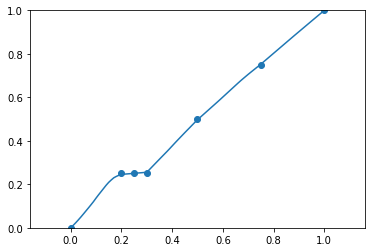

In [123]:
preds = model(torch.arange(-0.1, 1.1, 0.01).view(-1, 1)).view(-1).detach().numpy()
plt.scatter(data, labels)
plt.plot(np.arange(-0.1, 1.1, 0.01), preds)
plt.ylim(0, 1)
plt.show()

## Beyond simple Jacobian regularization

In [637]:
def get_model(num_neurons):
    nn = NN(num_neurons)
    return nn, optim.SGD(nn.parameters(), lr=1e-4)

In [638]:
class TangentProp(Callback):
    
    def __init__(self, mu, num_outputs):
        self.mu = mu
        self.num_outputs = num_outputs
    
    def on_backward_begin(self):
        
#         for m in self.state_dict['model'].modules():
#             if isinstance(m, nn.BatchNorm1d):
#                 m.eval()
        
        local_invariance_loss = 0
        
        for x in self.state_dict['xb']:
            jacobian = get_jacobian(self.state_dict['model'], x.view(-1, 1).float(), self.num_outputs)
#             tangent_vector = T(get_tangent_vector(np.array(x))).view(-1, 1)
            directional_derivative = jacobian #@ tangent_vector.float()
#             print(directional_derivative)
            norm = torch.sum((directional_derivative) ** 2)
            local_invariance_loss += norm
    
#         print(local_invariance_loss * self.mu, self.state_dict['lossb'])
        
        self.state_dict['lossb'] = self.state_dict['lossb'] + self.mu * local_invariance_loss
        
        # nn.BatchNorm1d will be reset to trainable at the beginning of next batch iteration
        # its gradient is not deleted by eval() mode

In [639]:
model, opt = get_model(100)
        # nn.BatchNorm1d will be reset to trainable a
def loss(ypred, y):
    return torch.sum((ypred-y) ** 2) / y.size(0)
learn = Learner(train_dl, valid_dl, model, loss, opt)

loss_cb = LossCallback()
cb_handler = CallbackHandler(cbs=[loss_cb, acc_cb, TangentProp(mu=1e-2, num_outputs=1)])

trainer = Trainer(learn=learn, cb_handler=cb_handler)
trainer.find_lr(beta=0.98, final_value=1e1, num_itr=100)

RuntimeError: grad can be implicitly created only for scalar outputs

In [608]:
trainer.set_lr(1e-2)
trainer.train(10)

(tensor([[0.0376]], grad_fn=<TBackward>),)
(tensor([[0.0376]], grad_fn=<TBackward>),)
(tensor([[0.0418]], grad_fn=<TBackward>),)
(tensor([[0.0103]], grad_fn=<TBackward>),)
(tensor([[0.0145]], grad_fn=<TBackward>),)
(tensor([[0.0273]], grad_fn=<TBackward>),)
(tensor([[0.0273]], grad_fn=<TBackward>),)
(tensor([[0.0103]], grad_fn=<TBackward>),)
(tensor([[0.0103]], grad_fn=<TBackward>),)
(tensor([[0.0103]], grad_fn=<TBackward>),)
(tensor([[0.0418]], grad_fn=<TBackward>),)
(tensor([[0.0145]], grad_fn=<TBackward>),)
(tensor([[0.0376]], grad_fn=<TBackward>),)
(tensor([[0.0273]], grad_fn=<TBackward>),)
(tensor([[0.0103]], grad_fn=<TBackward>),)
(tensor([[0.0376]], grad_fn=<TBackward>),)
(tensor([[0.0418]], grad_fn=<TBackward>),)
(tensor([[0.0145]], grad_fn=<TBackward>),)
(tensor([[0.0145]], grad_fn=<TBackward>),)
(tensor([[0.0273]], grad_fn=<TBackward>),)
(tensor([[0.0145]], grad_fn=<TBackward>),)
(tensor([[0.0273]], grad_fn=<TBackward>),)
(tensor([[0.0103]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.0640]], grad_fn=<TBackward>),)
(tensor([[0.0467]], grad_fn=<TBackward>),)
(tensor([[0.0369]], grad_fn=<TBackward>),)
(tensor([[0.0420]], grad_fn=<TBackward>),)
(tensor([[0.0467]], grad_fn=<TBackward>),)
(tensor([[0.0262]], grad_fn=<TBackward>),)
(tensor([[0.0369]], grad_fn=<TBackward>),)
(tensor([[0.0467]], grad_fn=<TBackward>),)
(tensor([[0.0640]], grad_fn=<TBackward>),)
(tensor([[0.0467]], grad_fn=<TBackward>),)
(tensor([[0.0369]], grad_fn=<TBackward>),)
(tensor([[0.0262]], grad_fn=<TBackward>),)
(tensor([[0.0640]], grad_fn=<TBackward>),)
(tensor([[0.0640]], grad_fn=<TBackward>),)
(tensor([[0.0640]], grad_fn=<TBackward>),)
(tensor([[0.0262]], grad_fn=<TBackward>),)
(tensor([[0.0467]], grad_fn=<TBackward>),)
(tensor([[0.0640]], grad_fn=<TBackward>),)
(tensor([[0.0420]], grad_fn=<TBackward>),)
(tensor([[0.0369]], grad_fn=<TBackward>),)
(tensor([[0.0369]], grad_fn=<TBackward>),)
(tensor([[0.0369]], grad_fn=<TBackward>),)
(tensor([[0.0262]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.0598]], grad_fn=<TBackward>),)
(tensor([[0.0598]], grad_fn=<TBackward>),)
(tensor([[0.0582]], grad_fn=<TBackward>),)
(tensor([[0.0598]], grad_fn=<TBackward>),)
(tensor([[0.0434]], grad_fn=<TBackward>),)
(tensor([[0.0845]], grad_fn=<TBackward>),)
(tensor([[0.0635]], grad_fn=<TBackward>),)
(tensor([[0.0644]], grad_fn=<TBackward>),)
(tensor([[0.0644]], grad_fn=<TBackward>),)
(tensor([[0.0644]], grad_fn=<TBackward>),)
(tensor([[0.0685]], grad_fn=<TBackward>),)
(tensor([[0.0685]], grad_fn=<TBackward>),)
(tensor([[0.0845]], grad_fn=<TBackward>),)
(tensor([[0.0685]], grad_fn=<TBackward>),)
(tensor([[0.0459]], grad_fn=<TBackward>),)
(tensor([[0.0644]], grad_fn=<TBackward>),)
(tensor([[0.0635]], grad_fn=<TBackward>),)
(tensor([[0.0845]], grad_fn=<TBackward>),)
(tensor([[0.0845]], grad_fn=<TBackward>),)
(tensor([[0.0685]], grad_fn=<TBackward>),)
(tensor([[0.0685]], grad_fn=<TBackward>),)
(tensor([[0.0685]], grad_fn=<TBackward>),)
(tensor([[0.0459]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.0680]], grad_fn=<TBackward>),)
(tensor([[0.0819]], grad_fn=<TBackward>),)
(tensor([[0.0296]], grad_fn=<TBackward>),)
(tensor([[0.0819]], grad_fn=<TBackward>),)
(tensor([[0.0830]], grad_fn=<TBackward>),)
(tensor([[0.0680]], grad_fn=<TBackward>),)
(tensor([[0.0680]], grad_fn=<TBackward>),)
(tensor([[0.0296]], grad_fn=<TBackward>),)
(tensor([[0.0680]], grad_fn=<TBackward>),)
(tensor([[0.0296]], grad_fn=<TBackward>),)
(tensor([[0.0680]], grad_fn=<TBackward>),)
(tensor([[0.0680]], grad_fn=<TBackward>),)
(tensor([[0.0296]], grad_fn=<TBackward>),)
(tensor([[0.0694]], grad_fn=<TBackward>),)
(tensor([[0.0296]], grad_fn=<TBackward>),)
(tensor([[0.0694]], grad_fn=<TBackward>),)
(tensor([[0.0694]], grad_fn=<TBackward>),)
(tensor([[0.0830]], grad_fn=<TBackward>),)
(tensor([[0.0830]], grad_fn=<TBackward>),)
(tensor([[0.0830]], grad_fn=<TBackward>),)
(tensor([[0.0819]], grad_fn=<TBackward>),)
(tensor([[0.0830]], grad_fn=<TBackward>),)
(tensor([[0.0694]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1070]], grad_fn=<TBackward>),)
(tensor([[0.0474]], grad_fn=<TBackward>),)
(tensor([[0.0900]], grad_fn=<TBackward>),)
(tensor([[0.0886]], grad_fn=<TBackward>),)
(tensor([[0.0886]], grad_fn=<TBackward>),)
(tensor([[0.0900]], grad_fn=<TBackward>),)
(tensor([[0.1070]], grad_fn=<TBackward>),)
(tensor([[0.1070]], grad_fn=<TBackward>),)
(tensor([[0.0886]], grad_fn=<TBackward>),)
(tensor([[0.0900]], grad_fn=<TBackward>),)
(tensor([[0.0474]], grad_fn=<TBackward>),)
(tensor([[0.0995]], grad_fn=<TBackward>),)
(tensor([[0.0900]], grad_fn=<TBackward>),)
(tensor([[0.0886]], grad_fn=<TBackward>),)
(tensor([[0.0995]], grad_fn=<TBackward>),)
(tensor([[0.0474]], grad_fn=<TBackward>),)
(tensor([[0.0900]], grad_fn=<TBackward>),)
(tensor([[0.0474]], grad_fn=<TBackward>),)
(tensor([[0.0995]], grad_fn=<TBackward>),)
(tensor([[0.1070]], grad_fn=<TBackward>),)
(tensor([[0.0474]], grad_fn=<TBackward>),)
(tensor([[0.0474]], grad_fn=<TBackward>),)
(tensor([[0.0900]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1169]], grad_fn=<TBackward>),)
(tensor([[0.0604]], grad_fn=<TBackward>),)
(tensor([[0.0604]], grad_fn=<TBackward>),)
(tensor([[0.0604]], grad_fn=<TBackward>),)
(tensor([[0.1189]], grad_fn=<TBackward>),)
(tensor([[0.0604]], grad_fn=<TBackward>),)
(tensor([[0.0991]], grad_fn=<TBackward>),)
(tensor([[0.0604]], grad_fn=<TBackward>),)
(tensor([[0.0604]], grad_fn=<TBackward>),)
(tensor([[0.1103]], grad_fn=<TBackward>),)
(tensor([[0.1103]], grad_fn=<TBackward>),)
(tensor([[0.1169]], grad_fn=<TBackward>),)
(tensor([[0.0991]], grad_fn=<TBackward>),)
(tensor([[0.1103]], grad_fn=<TBackward>),)
(tensor([[0.1169]], grad_fn=<TBackward>),)
(tensor([[0.0604]], grad_fn=<TBackward>),)
(tensor([[0.1103]], grad_fn=<TBackward>),)
(tensor([[0.0604]], grad_fn=<TBackward>),)
(tensor([[0.1169]], grad_fn=<TBackward>),)
(tensor([[0.1103]], grad_fn=<TBackward>),)
(tensor([[0.0604]], grad_fn=<TBackward>),)
(tensor([[0.1189]], grad_fn=<TBackward>),)
(tensor([[0.1169]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.0682]], grad_fn=<TBackward>),)
(tensor([[0.0682]], grad_fn=<TBackward>),)
(tensor([[0.1207]], grad_fn=<TBackward>),)
(tensor([[0.1274]], grad_fn=<TBackward>),)
(tensor([[0.1207]], grad_fn=<TBackward>),)
(tensor([[0.1274]], grad_fn=<TBackward>),)
(tensor([[0.1226]], grad_fn=<TBackward>),)
(tensor([[0.1274]], grad_fn=<TBackward>),)
(tensor([[0.0682]], grad_fn=<TBackward>),)
(tensor([[0.1274]], grad_fn=<TBackward>),)
(tensor([[0.1274]], grad_fn=<TBackward>),)
(tensor([[0.1226]], grad_fn=<TBackward>),)
(tensor([[0.0682]], grad_fn=<TBackward>),)
(tensor([[0.1226]], grad_fn=<TBackward>),)
(tensor([[0.1274]], grad_fn=<TBackward>),)
(tensor([[0.1207]], grad_fn=<TBackward>),)
(tensor([[0.1065]], grad_fn=<TBackward>),)
(tensor([[0.1274]], grad_fn=<TBackward>),)
(tensor([[0.1274]], grad_fn=<TBackward>),)
(tensor([[0.1207]], grad_fn=<TBackward>),)
(tensor([[0.1274]], grad_fn=<TBackward>),)
(tensor([[0.1226]], grad_fn=<TBackward>),)
(tensor([[0.1274]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.0804]], grad_fn=<TBackward>),)
(tensor([[0.1319]], grad_fn=<TBackward>),)
(tensor([[0.0804]], grad_fn=<TBackward>),)
(tensor([[0.1349]], grad_fn=<TBackward>),)
(tensor([[0.1319]], grad_fn=<TBackward>),)
(tensor([[0.0804]], grad_fn=<TBackward>),)
(tensor([[0.1409]], grad_fn=<TBackward>),)
(tensor([[0.1319]], grad_fn=<TBackward>),)
(tensor([[0.1349]], grad_fn=<TBackward>),)
(tensor([[0.0804]], grad_fn=<TBackward>),)
(tensor([[0.1185]], grad_fn=<TBackward>),)
(tensor([[0.1319]], grad_fn=<TBackward>),)
(tensor([[0.1319]], grad_fn=<TBackward>),)
(tensor([[0.0804]], grad_fn=<TBackward>),)
(tensor([[0.1319]], grad_fn=<TBackward>),)
(tensor([[0.1319]], grad_fn=<TBackward>),)
(tensor([[0.1319]], grad_fn=<TBackward>),)
(tensor([[0.0804]], grad_fn=<TBackward>),)
(tensor([[0.1185]], grad_fn=<TBackward>),)
(tensor([[0.1319]], grad_fn=<TBackward>),)
(tensor([[0.1319]], grad_fn=<TBackward>),)
(tensor([[0.0804]], grad_fn=<TBackward>),)
(tensor([[0.1319]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1412]], grad_fn=<TBackward>),)
(tensor([[0.1412]], grad_fn=<TBackward>),)
(tensor([[0.0924]], grad_fn=<TBackward>),)
(tensor([[0.0924]], grad_fn=<TBackward>),)
(tensor([[0.1412]], grad_fn=<TBackward>),)
(tensor([[0.1499]], grad_fn=<TBackward>),)
(tensor([[0.1411]], grad_fn=<TBackward>),)
(tensor([[0.1453]], grad_fn=<TBackward>),)
(tensor([[0.1411]], grad_fn=<TBackward>),)
(tensor([[0.1499]], grad_fn=<TBackward>),)
(tensor([[0.0924]], grad_fn=<TBackward>),)
(tensor([[0.1453]], grad_fn=<TBackward>),)
(tensor([[0.1453]], grad_fn=<TBackward>),)
(tensor([[0.1412]], grad_fn=<TBackward>),)
(tensor([[0.1412]], grad_fn=<TBackward>),)
(tensor([[0.1499]], grad_fn=<TBackward>),)
(tensor([[0.1453]], grad_fn=<TBackward>),)
(tensor([[0.1411]], grad_fn=<TBackward>),)
(tensor([[0.1411]], grad_fn=<TBackward>),)
(tensor([[0.1499]], grad_fn=<TBackward>),)
(tensor([[0.1453]], grad_fn=<TBackward>),)
(tensor([[0.1411]], grad_fn=<TBackward>),)
(tensor([[0.0924]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1492]], grad_fn=<TBackward>),)
(tensor([[0.1503]], grad_fn=<TBackward>),)
(tensor([[0.1612]], grad_fn=<TBackward>),)
(tensor([[0.1437]], grad_fn=<TBackward>),)
(tensor([[0.1503]], grad_fn=<TBackward>),)
(tensor([[0.1492]], grad_fn=<TBackward>),)
(tensor([[0.1612]], grad_fn=<TBackward>),)
(tensor([[0.1612]], grad_fn=<TBackward>),)
(tensor([[0.1612]], grad_fn=<TBackward>),)
(tensor([[0.1437]], grad_fn=<TBackward>),)
(tensor([[0.1492]], grad_fn=<TBackward>),)
(tensor([[0.1492]], grad_fn=<TBackward>),)
(tensor([[0.1503]], grad_fn=<TBackward>),)
(tensor([[0.1612]], grad_fn=<TBackward>),)
(tensor([[0.1503]], grad_fn=<TBackward>),)
(tensor([[0.0967]], grad_fn=<TBackward>),)
(tensor([[0.0967]], grad_fn=<TBackward>),)
(tensor([[0.1437]], grad_fn=<TBackward>),)
(tensor([[0.1492]], grad_fn=<TBackward>),)
(tensor([[0.0967]], grad_fn=<TBackward>),)
(tensor([[0.1503]], grad_fn=<TBackward>),)
(tensor([[0.0967]], grad_fn=<TBackward>),)
(tensor([[0.0967]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1580]], grad_fn=<TBackward>),)
(tensor([[0.1516]], grad_fn=<TBackward>),)
(tensor([[0.1026]], grad_fn=<TBackward>),)
(tensor([[0.1026]], grad_fn=<TBackward>),)
(tensor([[0.1026]], grad_fn=<TBackward>),)
(tensor([[0.1708]], grad_fn=<TBackward>),)
(tensor([[0.1580]], grad_fn=<TBackward>),)
(tensor([[0.1539]], grad_fn=<TBackward>),)
(tensor([[0.1580]], grad_fn=<TBackward>),)
(tensor([[0.1580]], grad_fn=<TBackward>),)
(tensor([[0.1708]], grad_fn=<TBackward>),)
(tensor([[0.1026]], grad_fn=<TBackward>),)
(tensor([[0.1516]], grad_fn=<TBackward>),)
(tensor([[0.1026]], grad_fn=<TBackward>),)
(tensor([[0.1580]], grad_fn=<TBackward>),)
(tensor([[0.1026]], grad_fn=<TBackward>),)
(tensor([[0.1539]], grad_fn=<TBackward>),)
(tensor([[0.1580]], grad_fn=<TBackward>),)
(tensor([[0.1580]], grad_fn=<TBackward>),)
(tensor([[0.1539]], grad_fn=<TBackward>),)
(tensor([[0.1026]], grad_fn=<TBackward>),)
(tensor([[0.1580]], grad_fn=<TBackward>),)
(tensor([[0.1580]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1653]], grad_fn=<TBackward>),)
(tensor([[0.1771]], grad_fn=<TBackward>),)
(tensor([[0.1771]], grad_fn=<TBackward>),)
(tensor([[0.1771]], grad_fn=<TBackward>),)
(tensor([[0.1553]], grad_fn=<TBackward>),)
(tensor([[0.1102]], grad_fn=<TBackward>),)
(tensor([[0.1653]], grad_fn=<TBackward>),)
(tensor([[0.1553]], grad_fn=<TBackward>),)
(tensor([[0.1748]], grad_fn=<TBackward>),)
(tensor([[0.1748]], grad_fn=<TBackward>),)
(tensor([[0.1553]], grad_fn=<TBackward>),)
(tensor([[0.1553]], grad_fn=<TBackward>),)
(tensor([[0.1653]], grad_fn=<TBackward>),)
(tensor([[0.1748]], grad_fn=<TBackward>),)
(tensor([[0.1653]], grad_fn=<TBackward>),)
(tensor([[0.1102]], grad_fn=<TBackward>),)
(tensor([[0.1653]], grad_fn=<TBackward>),)
(tensor([[0.1553]], grad_fn=<TBackward>),)
(tensor([[0.1553]], grad_fn=<TBackward>),)
(tensor([[0.1771]], grad_fn=<TBackward>),)
(tensor([[0.1102]], grad_fn=<TBackward>),)
(tensor([[0.1653]], grad_fn=<TBackward>),)
(tensor([[0.1748]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1690]], grad_fn=<TBackward>),)
(tensor([[0.1726]], grad_fn=<TBackward>),)
(tensor([[0.1690]], grad_fn=<TBackward>),)
(tensor([[0.1690]], grad_fn=<TBackward>),)
(tensor([[0.1773]], grad_fn=<TBackward>),)
(tensor([[0.1773]], grad_fn=<TBackward>),)
(tensor([[0.1160]], grad_fn=<TBackward>),)
(tensor([[0.1690]], grad_fn=<TBackward>),)
(tensor([[0.1849]], grad_fn=<TBackward>),)
(tensor([[0.1690]], grad_fn=<TBackward>),)
(tensor([[0.1690]], grad_fn=<TBackward>),)
(tensor([[0.1773]], grad_fn=<TBackward>),)
(tensor([[0.1773]], grad_fn=<TBackward>),)
(tensor([[0.1690]], grad_fn=<TBackward>),)
(tensor([[0.1849]], grad_fn=<TBackward>),)
(tensor([[0.1726]], grad_fn=<TBackward>),)
(tensor([[0.1690]], grad_fn=<TBackward>),)
(tensor([[0.1160]], grad_fn=<TBackward>),)
(tensor([[0.1160]], grad_fn=<TBackward>),)
(tensor([[0.1690]], grad_fn=<TBackward>),)
(tensor([[0.1849]], grad_fn=<TBackward>),)
(tensor([[0.1690]], grad_fn=<TBackward>),)
(tensor([[0.1773]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1722]], grad_fn=<TBackward>),)
(tensor([[0.1824]], grad_fn=<TBackward>),)
(tensor([[0.1722]], grad_fn=<TBackward>),)
(tensor([[0.1733]], grad_fn=<TBackward>),)
(tensor([[0.1824]], grad_fn=<TBackward>),)
(tensor([[0.1824]], grad_fn=<TBackward>),)
(tensor([[0.1160]], grad_fn=<TBackward>),)
(tensor([[0.1824]], grad_fn=<TBackward>),)
(tensor([[0.1824]], grad_fn=<TBackward>),)
(tensor([[0.1160]], grad_fn=<TBackward>),)
(tensor([[0.1722]], grad_fn=<TBackward>),)
(tensor([[0.1733]], grad_fn=<TBackward>),)
(tensor([[0.1733]], grad_fn=<TBackward>),)
(tensor([[0.1733]], grad_fn=<TBackward>),)
(tensor([[0.1872]], grad_fn=<TBackward>),)
(tensor([[0.1824]], grad_fn=<TBackward>),)
(tensor([[0.1733]], grad_fn=<TBackward>),)
(tensor([[0.1733]], grad_fn=<TBackward>),)
(tensor([[0.1824]], grad_fn=<TBackward>),)
(tensor([[0.1872]], grad_fn=<TBackward>),)
(tensor([[0.1722]], grad_fn=<TBackward>),)
(tensor([[0.1160]], grad_fn=<TBackward>),)
(tensor([[0.1824]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1878]], grad_fn=<TBackward>),)
(tensor([[0.1829]], grad_fn=<TBackward>),)
(tensor([[0.1741]], grad_fn=<TBackward>),)
(tensor([[0.1878]], grad_fn=<TBackward>),)
(tensor([[0.1213]], grad_fn=<TBackward>),)
(tensor([[0.1829]], grad_fn=<TBackward>),)
(tensor([[0.1878]], grad_fn=<TBackward>),)
(tensor([[0.1878]], grad_fn=<TBackward>),)
(tensor([[0.1878]], grad_fn=<TBackward>),)
(tensor([[0.1829]], grad_fn=<TBackward>),)
(tensor([[0.1829]], grad_fn=<TBackward>),)
(tensor([[0.1213]], grad_fn=<TBackward>),)
(tensor([[0.1213]], grad_fn=<TBackward>),)
(tensor([[0.1741]], grad_fn=<TBackward>),)
(tensor([[0.1829]], grad_fn=<TBackward>),)
(tensor([[0.1741]], grad_fn=<TBackward>),)
(tensor([[0.1213]], grad_fn=<TBackward>),)
(tensor([[0.1683]], grad_fn=<TBackward>),)
(tensor([[0.1683]], grad_fn=<TBackward>),)
(tensor([[0.1878]], grad_fn=<TBackward>),)
(tensor([[0.1741]], grad_fn=<TBackward>),)
(tensor([[0.1741]], grad_fn=<TBackward>),)
(tensor([[0.1878]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1208]], grad_fn=<TBackward>),)
(tensor([[0.1786]], grad_fn=<TBackward>),)
(tensor([[0.1826]], grad_fn=<TBackward>),)
(tensor([[0.1826]], grad_fn=<TBackward>),)
(tensor([[0.1208]], grad_fn=<TBackward>),)
(tensor([[0.1864]], grad_fn=<TBackward>),)
(tensor([[0.1786]], grad_fn=<TBackward>),)
(tensor([[0.1864]], grad_fn=<TBackward>),)
(tensor([[0.1826]], grad_fn=<TBackward>),)
(tensor([[0.1864]], grad_fn=<TBackward>),)
(tensor([[0.1826]], grad_fn=<TBackward>),)
(tensor([[0.1208]], grad_fn=<TBackward>),)
(tensor([[0.1208]], grad_fn=<TBackward>),)
(tensor([[0.1208]], grad_fn=<TBackward>),)
(tensor([[0.1918]], grad_fn=<TBackward>),)
(tensor([[0.1826]], grad_fn=<TBackward>),)
(tensor([[0.1208]], grad_fn=<TBackward>),)
(tensor([[0.1826]], grad_fn=<TBackward>),)
(tensor([[0.1864]], grad_fn=<TBackward>),)
(tensor([[0.1208]], grad_fn=<TBackward>),)
(tensor([[0.1864]], grad_fn=<TBackward>),)
(tensor([[0.1918]], grad_fn=<TBackward>),)
(tensor([[0.1786]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1249]], grad_fn=<TBackward>),)
(tensor([[0.1896]], grad_fn=<TBackward>),)
(tensor([[0.1760]], grad_fn=<TBackward>),)
(tensor([[0.1870]], grad_fn=<TBackward>),)
(tensor([[0.1909]], grad_fn=<TBackward>),)
(tensor([[0.1870]], grad_fn=<TBackward>),)
(tensor([[0.1249]], grad_fn=<TBackward>),)
(tensor([[0.1760]], grad_fn=<TBackward>),)
(tensor([[0.1870]], grad_fn=<TBackward>),)
(tensor([[0.1249]], grad_fn=<TBackward>),)
(tensor([[0.1870]], grad_fn=<TBackward>),)
(tensor([[0.1249]], grad_fn=<TBackward>),)
(tensor([[0.1249]], grad_fn=<TBackward>),)
(tensor([[0.1760]], grad_fn=<TBackward>),)
(tensor([[0.1760]], grad_fn=<TBackward>),)
(tensor([[0.1896]], grad_fn=<TBackward>),)
(tensor([[0.1870]], grad_fn=<TBackward>),)
(tensor([[0.1760]], grad_fn=<TBackward>),)
(tensor([[0.1249]], grad_fn=<TBackward>),)
(tensor([[0.1249]], grad_fn=<TBackward>),)
(tensor([[0.1870]], grad_fn=<TBackward>),)
(tensor([[0.1760]], grad_fn=<TBackward>),)
(tensor([[0.1909]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1925]], grad_fn=<TBackward>),)
(tensor([[0.1781]], grad_fn=<TBackward>),)
(tensor([[0.1925]], grad_fn=<TBackward>),)
(tensor([[0.1930]], grad_fn=<TBackward>),)
(tensor([[0.1925]], grad_fn=<TBackward>),)
(tensor([[0.1781]], grad_fn=<TBackward>),)
(tensor([[0.1925]], grad_fn=<TBackward>),)
(tensor([[0.1916]], grad_fn=<TBackward>),)
(tensor([[0.1930]], grad_fn=<TBackward>),)
(tensor([[0.1781]], grad_fn=<TBackward>),)
(tensor([[0.1916]], grad_fn=<TBackward>),)
(tensor([[0.1781]], grad_fn=<TBackward>),)
(tensor([[0.1916]], grad_fn=<TBackward>),)
(tensor([[0.1781]], grad_fn=<TBackward>),)
(tensor([[0.1930]], grad_fn=<TBackward>),)
(tensor([[0.1781]], grad_fn=<TBackward>),)
(tensor([[0.1930]], grad_fn=<TBackward>),)
(tensor([[0.1930]], grad_fn=<TBackward>),)
(tensor([[0.1930]], grad_fn=<TBackward>),)
(tensor([[0.1925]], grad_fn=<TBackward>),)
(tensor([[0.1781]], grad_fn=<TBackward>),)
(tensor([[0.1925]], grad_fn=<TBackward>),)
(tensor([[0.1266]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1889]], grad_fn=<TBackward>),)
(tensor([[0.1901]], grad_fn=<TBackward>),)
(tensor([[0.1245]], grad_fn=<TBackward>),)
(tensor([[0.1245]], grad_fn=<TBackward>),)
(tensor([[0.2029]], grad_fn=<TBackward>),)
(tensor([[0.1889]], grad_fn=<TBackward>),)
(tensor([[0.1889]], grad_fn=<TBackward>),)
(tensor([[0.1245]], grad_fn=<TBackward>),)
(tensor([[0.1245]], grad_fn=<TBackward>),)
(tensor([[0.2029]], grad_fn=<TBackward>),)
(tensor([[0.1889]], grad_fn=<TBackward>),)
(tensor([[0.1245]], grad_fn=<TBackward>),)
(tensor([[0.1889]], grad_fn=<TBackward>),)
(tensor([[0.1750]], grad_fn=<TBackward>),)
(tensor([[0.2029]], grad_fn=<TBackward>),)
(tensor([[0.2029]], grad_fn=<TBackward>),)
(tensor([[0.1245]], grad_fn=<TBackward>),)
(tensor([[0.1889]], grad_fn=<TBackward>),)
(tensor([[0.1901]], grad_fn=<TBackward>),)
(tensor([[0.1750]], grad_fn=<TBackward>),)
(tensor([[0.1901]], grad_fn=<TBackward>),)
(tensor([[0.1245]], grad_fn=<TBackward>),)
(tensor([[0.1750]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1825]], grad_fn=<TBackward>),)
(tensor([[0.1825]], grad_fn=<TBackward>),)
(tensor([[0.1886]], grad_fn=<TBackward>),)
(tensor([[0.2200]], grad_fn=<TBackward>),)
(tensor([[0.1300]], grad_fn=<TBackward>),)
(tensor([[0.2166]], grad_fn=<TBackward>),)
(tensor([[0.1886]], grad_fn=<TBackward>),)
(tensor([[0.2200]], grad_fn=<TBackward>),)
(tensor([[0.1886]], grad_fn=<TBackward>),)
(tensor([[0.2200]], grad_fn=<TBackward>),)
(tensor([[0.1300]], grad_fn=<TBackward>),)
(tensor([[0.2166]], grad_fn=<TBackward>),)
(tensor([[0.1300]], grad_fn=<TBackward>),)
(tensor([[0.2166]], grad_fn=<TBackward>),)
(tensor([[0.1300]], grad_fn=<TBackward>),)
(tensor([[0.1300]], grad_fn=<TBackward>),)
(tensor([[0.1300]], grad_fn=<TBackward>),)
(tensor([[0.1886]], grad_fn=<TBackward>),)
(tensor([[0.1886]], grad_fn=<TBackward>),)
(tensor([[0.2166]], grad_fn=<TBackward>),)
(tensor([[0.2200]], grad_fn=<TBackward>),)
(tensor([[0.2166]], grad_fn=<TBackward>),)
(tensor([[0.1886]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1868]], grad_fn=<TBackward>),)
(tensor([[0.2143]], grad_fn=<TBackward>),)
(tensor([[0.1868]], grad_fn=<TBackward>),)
(tensor([[0.1287]], grad_fn=<TBackward>),)
(tensor([[0.1868]], grad_fn=<TBackward>),)
(tensor([[0.1287]], grad_fn=<TBackward>),)
(tensor([[0.1868]], grad_fn=<TBackward>),)
(tensor([[0.2178]], grad_fn=<TBackward>),)
(tensor([[0.2178]], grad_fn=<TBackward>),)
(tensor([[0.1287]], grad_fn=<TBackward>),)
(tensor([[0.1287]], grad_fn=<TBackward>),)
(tensor([[0.1868]], grad_fn=<TBackward>),)
(tensor([[0.1798]], grad_fn=<TBackward>),)
(tensor([[0.1287]], grad_fn=<TBackward>),)
(tensor([[0.2178]], grad_fn=<TBackward>),)
(tensor([[0.1868]], grad_fn=<TBackward>),)
(tensor([[0.2143]], grad_fn=<TBackward>),)
(tensor([[0.2178]], grad_fn=<TBackward>),)
(tensor([[0.2178]], grad_fn=<TBackward>),)
(tensor([[0.1287]], grad_fn=<TBackward>),)
(tensor([[0.1798]], grad_fn=<TBackward>),)
(tensor([[0.1798]], grad_fn=<TBackward>),)
(tensor([[0.2143]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.2193]], grad_fn=<TBackward>),)
(tensor([[0.1877]], grad_fn=<TBackward>),)
(tensor([[0.1877]], grad_fn=<TBackward>),)
(tensor([[0.2156]], grad_fn=<TBackward>),)
(tensor([[0.1877]], grad_fn=<TBackward>),)
(tensor([[0.1258]], grad_fn=<TBackward>),)
(tensor([[0.1877]], grad_fn=<TBackward>),)
(tensor([[0.1855]], grad_fn=<TBackward>),)
(tensor([[0.1258]], grad_fn=<TBackward>),)
(tensor([[0.2193]], grad_fn=<TBackward>),)
(tensor([[0.2193]], grad_fn=<TBackward>),)
(tensor([[0.1855]], grad_fn=<TBackward>),)
(tensor([[0.1258]], grad_fn=<TBackward>),)
(tensor([[0.1877]], grad_fn=<TBackward>),)
(tensor([[0.1877]], grad_fn=<TBackward>),)
(tensor([[0.1258]], grad_fn=<TBackward>),)
(tensor([[0.2193]], grad_fn=<TBackward>),)
(tensor([[0.2193]], grad_fn=<TBackward>),)
(tensor([[0.1877]], grad_fn=<TBackward>),)
(tensor([[0.2156]], grad_fn=<TBackward>),)
(tensor([[0.1855]], grad_fn=<TBackward>),)
(tensor([[0.2156]], grad_fn=<TBackward>),)
(tensor([[0.1258]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1862]], grad_fn=<TBackward>),)
(tensor([[0.1357]], grad_fn=<TBackward>),)
(tensor([[0.2332]], grad_fn=<TBackward>),)
(tensor([[0.1782]], grad_fn=<TBackward>),)
(tensor([[0.2274]], grad_fn=<TBackward>),)
(tensor([[0.1782]], grad_fn=<TBackward>),)
(tensor([[0.1862]], grad_fn=<TBackward>),)
(tensor([[0.2274]], grad_fn=<TBackward>),)
(tensor([[0.2274]], grad_fn=<TBackward>),)
(tensor([[0.1357]], grad_fn=<TBackward>),)
(tensor([[0.2274]], grad_fn=<TBackward>),)
(tensor([[0.1862]], grad_fn=<TBackward>),)
(tensor([[0.1357]], grad_fn=<TBackward>),)
(tensor([[0.2332]], grad_fn=<TBackward>),)
(tensor([[0.2274]], grad_fn=<TBackward>),)
(tensor([[0.2332]], grad_fn=<TBackward>),)
(tensor([[0.2274]], grad_fn=<TBackward>),)
(tensor([[0.2332]], grad_fn=<TBackward>),)
(tensor([[0.1782]], grad_fn=<TBackward>),)
(tensor([[0.1357]], grad_fn=<TBackward>),)
(tensor([[0.2332]], grad_fn=<TBackward>),)
(tensor([[0.1782]], grad_fn=<TBackward>),)
(tensor([[0.2332]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1860]], grad_fn=<TBackward>),)
(tensor([[0.1885]], grad_fn=<TBackward>),)
(tensor([[0.2274]], grad_fn=<TBackward>),)
(tensor([[0.1885]], grad_fn=<TBackward>),)
(tensor([[0.2274]], grad_fn=<TBackward>),)
(tensor([[0.1323]], grad_fn=<TBackward>),)
(tensor([[0.1323]], grad_fn=<TBackward>),)
(tensor([[0.1860]], grad_fn=<TBackward>),)
(tensor([[0.2371]], grad_fn=<TBackward>),)
(tensor([[0.2371]], grad_fn=<TBackward>),)
(tensor([[0.2371]], grad_fn=<TBackward>),)
(tensor([[0.2371]], grad_fn=<TBackward>),)
(tensor([[0.1323]], grad_fn=<TBackward>),)
(tensor([[0.2274]], grad_fn=<TBackward>),)
(tensor([[0.2371]], grad_fn=<TBackward>),)
(tensor([[0.2371]], grad_fn=<TBackward>),)
(tensor([[0.2371]], grad_fn=<TBackward>),)
(tensor([[0.1860]], grad_fn=<TBackward>),)
(tensor([[0.1885]], grad_fn=<TBackward>),)
(tensor([[0.1860]], grad_fn=<TBackward>),)
(tensor([[0.2274]], grad_fn=<TBackward>),)
(tensor([[0.1860]], grad_fn=<TBackward>),)
(tensor([[0.1860]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.2246]], grad_fn=<TBackward>),)
(tensor([[0.1861]], grad_fn=<TBackward>),)
(tensor([[0.1340]], grad_fn=<TBackward>),)
(tensor([[0.2246]], grad_fn=<TBackward>),)
(tensor([[0.1809]], grad_fn=<TBackward>),)
(tensor([[0.2246]], grad_fn=<TBackward>),)
(tensor([[0.2342]], grad_fn=<TBackward>),)
(tensor([[0.1809]], grad_fn=<TBackward>),)
(tensor([[0.2342]], grad_fn=<TBackward>),)
(tensor([[0.1861]], grad_fn=<TBackward>),)
(tensor([[0.1340]], grad_fn=<TBackward>),)
(tensor([[0.1861]], grad_fn=<TBackward>),)
(tensor([[0.1861]], grad_fn=<TBackward>),)
(tensor([[0.1861]], grad_fn=<TBackward>),)
(tensor([[0.1861]], grad_fn=<TBackward>),)
(tensor([[0.1861]], grad_fn=<TBackward>),)
(tensor([[0.2342]], grad_fn=<TBackward>),)
(tensor([[0.1340]], grad_fn=<TBackward>),)
(tensor([[0.1861]], grad_fn=<TBackward>),)
(tensor([[0.1340]], grad_fn=<TBackward>),)
(tensor([[0.1861]], grad_fn=<TBackward>),)
(tensor([[0.2342]], grad_fn=<TBackward>),)
(tensor([[0.1861]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1912]], grad_fn=<TBackward>),)
(tensor([[0.1912]], grad_fn=<TBackward>),)
(tensor([[0.1277]], grad_fn=<TBackward>),)
(tensor([[0.2353]], grad_fn=<TBackward>),)
(tensor([[0.1277]], grad_fn=<TBackward>),)
(tensor([[0.2353]], grad_fn=<TBackward>),)
(tensor([[0.1866]], grad_fn=<TBackward>),)
(tensor([[0.1866]], grad_fn=<TBackward>),)
(tensor([[0.2256]], grad_fn=<TBackward>),)
(tensor([[0.1912]], grad_fn=<TBackward>),)
(tensor([[0.2256]], grad_fn=<TBackward>),)
(tensor([[0.1866]], grad_fn=<TBackward>),)
(tensor([[0.2256]], grad_fn=<TBackward>),)
(tensor([[0.2256]], grad_fn=<TBackward>),)
(tensor([[0.2256]], grad_fn=<TBackward>),)
(tensor([[0.2353]], grad_fn=<TBackward>),)
(tensor([[0.2353]], grad_fn=<TBackward>),)
(tensor([[0.2353]], grad_fn=<TBackward>),)
(tensor([[0.1912]], grad_fn=<TBackward>),)
(tensor([[0.1277]], grad_fn=<TBackward>),)
(tensor([[0.1866]], grad_fn=<TBackward>),)
(tensor([[0.1277]], grad_fn=<TBackward>),)
(tensor([[0.1277]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1754]], grad_fn=<TBackward>),)
(tensor([[0.2196]], grad_fn=<TBackward>),)
(tensor([[0.1754]], grad_fn=<TBackward>),)
(tensor([[0.1754]], grad_fn=<TBackward>),)
(tensor([[0.2289]], grad_fn=<TBackward>),)
(tensor([[0.1314]], grad_fn=<TBackward>),)
(tensor([[0.2095]], grad_fn=<TBackward>),)
(tensor([[0.2289]], grad_fn=<TBackward>),)
(tensor([[0.2095]], grad_fn=<TBackward>),)
(tensor([[0.1314]], grad_fn=<TBackward>),)
(tensor([[0.2196]], grad_fn=<TBackward>),)
(tensor([[0.1754]], grad_fn=<TBackward>),)
(tensor([[0.2196]], grad_fn=<TBackward>),)
(tensor([[0.1754]], grad_fn=<TBackward>),)
(tensor([[0.2289]], grad_fn=<TBackward>),)
(tensor([[0.1314]], grad_fn=<TBackward>),)
(tensor([[0.2095]], grad_fn=<TBackward>),)
(tensor([[0.2196]], grad_fn=<TBackward>),)
(tensor([[0.2196]], grad_fn=<TBackward>),)
(tensor([[0.2289]], grad_fn=<TBackward>),)
(tensor([[0.1754]], grad_fn=<TBackward>),)
(tensor([[0.2095]], grad_fn=<TBackward>),)
(tensor([[0.1754]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.2214]], grad_fn=<TBackward>),)
(tensor([[0.1814]], grad_fn=<TBackward>),)
(tensor([[0.2214]], grad_fn=<TBackward>),)
(tensor([[0.1814]], grad_fn=<TBackward>),)
(tensor([[0.1324]], grad_fn=<TBackward>),)
(tensor([[0.2214]], grad_fn=<TBackward>),)
(tensor([[0.2214]], grad_fn=<TBackward>),)
(tensor([[0.1324]], grad_fn=<TBackward>),)
(tensor([[0.2214]], grad_fn=<TBackward>),)
(tensor([[0.2106]], grad_fn=<TBackward>),)
(tensor([[0.2106]], grad_fn=<TBackward>),)
(tensor([[0.2214]], grad_fn=<TBackward>),)
(tensor([[0.1814]], grad_fn=<TBackward>),)
(tensor([[0.2214]], grad_fn=<TBackward>),)
(tensor([[0.2106]], grad_fn=<TBackward>),)
(tensor([[0.1814]], grad_fn=<TBackward>),)
(tensor([[0.1814]], grad_fn=<TBackward>),)
(tensor([[0.2106]], grad_fn=<TBackward>),)
(tensor([[0.1324]], grad_fn=<TBackward>),)
(tensor([[0.2106]], grad_fn=<TBackward>),)
(tensor([[0.2353]], grad_fn=<TBackward>),)
(tensor([[0.2353]], grad_fn=<TBackward>),)
(tensor([[0.1814]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.1315]], grad_fn=<TBackward>),)
(tensor([[0.2336]], grad_fn=<TBackward>),)
(tensor([[0.2336]], grad_fn=<TBackward>),)
(tensor([[0.1315]], grad_fn=<TBackward>),)
(tensor([[0.2336]], grad_fn=<TBackward>),)
(tensor([[0.1841]], grad_fn=<TBackward>),)
(tensor([[0.2081]], grad_fn=<TBackward>),)
(tensor([[0.2336]], grad_fn=<TBackward>),)
(tensor([[0.1315]], grad_fn=<TBackward>),)
(tensor([[0.2081]], grad_fn=<TBackward>),)
(tensor([[0.2081]], grad_fn=<TBackward>),)
(tensor([[0.2195]], grad_fn=<TBackward>),)
(tensor([[0.1315]], grad_fn=<TBackward>),)
(tensor([[0.2081]], grad_fn=<TBackward>),)
(tensor([[0.1841]], grad_fn=<TBackward>),)
(tensor([[0.2336]], grad_fn=<TBackward>),)
(tensor([[0.2195]], grad_fn=<TBackward>),)
(tensor([[0.1841]], grad_fn=<TBackward>),)
(tensor([[0.1841]], grad_fn=<TBackward>),)
(tensor([[0.1841]], grad_fn=<TBackward>),)
(tensor([[0.2081]], grad_fn=<TBackward>),)
(tensor([[0.2336]], grad_fn=<TBackward>),)
(tensor([[0.1841]], grad_fn=<TBackward>),)
(tensor([[0

(tensor([[0.2051]], grad_fn=<TBackward>),)
(tensor([[0.2171]], grad_fn=<TBackward>),)
(tensor([[0.2051]], grad_fn=<TBackward>),)
(tensor([[0.2308]], grad_fn=<TBackward>),)
(tensor([[0.2051]], grad_fn=<TBackward>),)
(tensor([[0.2051]], grad_fn=<TBackward>),)
(tensor([[0.2308]], grad_fn=<TBackward>),)
(tensor([[0.2308]], grad_fn=<TBackward>),)
(tensor([[0.2308]], grad_fn=<TBackward>),)
(tensor([[0.1427]], grad_fn=<TBackward>),)
(tensor([[0.2051]], grad_fn=<TBackward>),)
(tensor([[0.2171]], grad_fn=<TBackward>),)
(tensor([[0.2308]], grad_fn=<TBackward>),)
(tensor([[0.1427]], grad_fn=<TBackward>),)
(tensor([[0.2171]], grad_fn=<TBackward>),)
(tensor([[0.1427]], grad_fn=<TBackward>),)
(tensor([[0.2171]], grad_fn=<TBackward>),)
(tensor([[0.2308]], grad_fn=<TBackward>),)
(tensor([[0.2308]], grad_fn=<TBackward>),)
(tensor([[0.2051]], grad_fn=<TBackward>),)
(tensor([[0.1868]], grad_fn=<TBackward>),)
(tensor([[0.1427]], grad_fn=<TBackward>),)
(tensor([[0.2051]], grad_fn=<TBackward>),)
(tensor([[0

In [609]:
tp = TangentProp(mu=1e-3, num_outputs=1)
trainer.cb_handler.cbs.append(tp)
tp.state_dict = trainer.cb_handler.state_dict

In [601]:
trainer.train(10)

KeyboardInterrupt: 

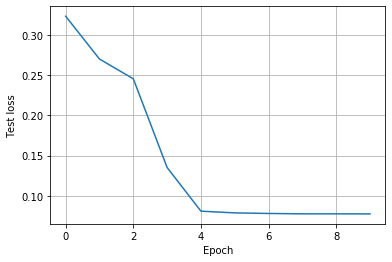

In [610]:
loss_cb.plot()
plt.show()

In [611]:
model = trainer.learn.model
xs = np.arange(0, 1+0.01, 0.001).reshape(-1, 1)
preds = model(T(xs).float()).detach().numpy().reshape(-1)

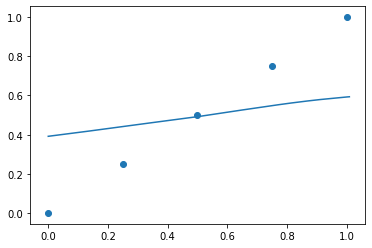

In [612]:
plt.plot(xs.reshape(-1), preds)
plt.scatter(np.arange(0, 1+0.25, 0.25), np.arange(0, 1+0.25, 0.25))
plt.show()

In [86]:
class TangentProp(Callback):
    
    def __init__(self, mu, num_outputs):
        self.mu = mu
        self.num_outputs = num_outputs
    
    def on_backward_begin(self):
        
        for m in self.state_dict['model'].modules():
            if isinstance(m, nn.BatchNorm1d):
                m.eval()
        
        local_invariance_loss = 0
        
        for x in self.state_dict['xb']:
            jacobian = get_jacobian(self.state_dict['model'], x.float(), self.num_outputs)
            tangent_vector = T(get_tangent_vector(np.array(x))).view(-1, 1)
            directional_derivative = jacobian @ tangent_vector.float()
            norm = torch.sum(directional_derivative ** 2)
            local_invariance_loss += norm
    
        print(local_invariance_loss * self.mu, self.state_dict['lossb'])
        
        self.state_dict['lossb'] = 2 * self.state_dict['lossb'] + self.mu * local_invariance_loss
        
        # nn.BatchNorm1d will be reset to trainable at the beginning of next batch iteration
        # its gradient is not deleted by eval() mode

tensor(0., grad_fn=<MulBackward0>) tensor(0.7122, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.6873, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.6884, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.6770, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.6820, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.6808, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.6912, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.6949, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.6807, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.6892, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.6697, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0

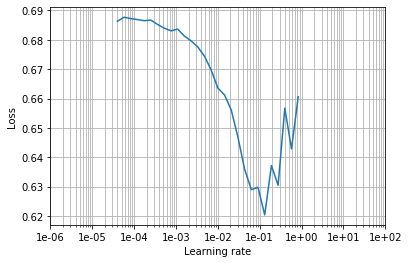

In [95]:
model, opt = get_model(50)
learn = Learner(train_dl, valid_dl, model, torch.nn.BCELoss(), opt)

loss_cb = LossCallback()
acc_cb = BinaryAccuracyCallback()
cb_handler = CallbackHandler(cbs=[loss_cb, acc_cb, TangentProp(mu=0, num_outputs=1)])

trainer = Trainer(learn=learn, cb_handler=cb_handler)
trainer.find_lr(beta=0.98, final_value=100, num_itr=50)

In [96]:
trainer.set_lr(2e-2)
trainer.train(10)

tensor(0., grad_fn=<MulBackward0>) tensor(0.7013, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.4900, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.5001, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.4600, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.3713, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.3417, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.3587, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.3226, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.3615, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2922, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2844, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0

tensor(0., grad_fn=<MulBackward0>) tensor(0.2858, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2508, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2774, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2033, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.3347, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2519, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2861, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2643, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2962, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2373, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2973, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0

tensor(0., grad_fn=<MulBackward0>) tensor(0.2280, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2700, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2468, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2183, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2042, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2438, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.3137, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2730, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2804, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.3000, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2908, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0

tensor(0., grad_fn=<MulBackward0>) tensor(0.2096, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2686, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2314, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2476, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1999, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2350, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2031, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.3304, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2640, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2271, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2189, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0

tensor(0., grad_fn=<MulBackward0>) tensor(0.1835, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2808, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2197, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1646, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2872, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2484, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1666, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.3397, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1789, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1784, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2400, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0

tensor(0., grad_fn=<MulBackward0>) tensor(0.2930, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1827, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1970, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2312, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2220, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1731, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2037, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2768, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2067, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2271, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2659, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0

tensor(0., grad_fn=<MulBackward0>) tensor(0.1708, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1978, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2197, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2884, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1895, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2229, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2189, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1860, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1653, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1320, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.4465, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0

tensor(0., grad_fn=<MulBackward0>) tensor(0.1967, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2041, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2362, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1923, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1747, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1908, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1359, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1362, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1857, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1704, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2130, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0

tensor(0., grad_fn=<MulBackward0>) tensor(0.1816, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1497, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1220, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.3704, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2828, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1514, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1523, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1981, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1284, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2499, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1267, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0

tensor(0., grad_fn=<MulBackward0>) tensor(0.2425, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.0929, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1218, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.0988, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.2144, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1259, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1060, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1191, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.3045, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1100, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0>) tensor(0.1325, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0., grad_fn=<MulBackward0

(0, 1)

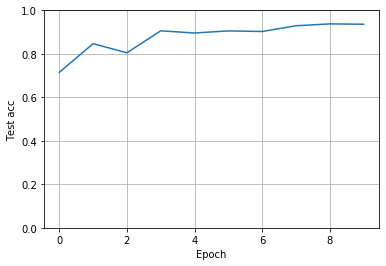

In [97]:
acc_cb.plot()
plt.ylim(0, 1)